# Vector Search with Midras

### Remote Version

To use cloud GPUs for generating ColPali embeddings, you'll need an API key from [midrasai](https://midrasai.com), just log in with github and generate new key.

In [1]:
import os

midras_key = os.getenv("MIDRAS_API_KEY")

Let's create our clients for Midras.

Midras uses Qdrant under the hood as an integrated vector database.
Because of this, you can use your own Qdrant instance or Qdrant Cloud with Midras.

For this demo, we will use an in-memory Qdrant database.

In [2]:
from midrasai import Midras

midras = Midras(api_key=midras_key, qdrant=":memory:")

Now let's create the collection where we will store all our data. It can be named whatever we want, in this case we will use the name *my_collection*.

In [3]:
midras.index.create_collection("my_collection")

True

Now we have our collection, but it's empty. Let's use the *embed_pdf* utility method to process a pdf file which we will then load into our collection.

The *embed_pdf* method accepts a path to a local pdf file and returns a response object with the ColBERT vector embeddings for each page in the pdf. Additionaly, if we set the parameter "include_images" to True, the response object will also return the list of PIL Images that were generated from the pdf.

**NOTE:** The *embed_pdf* method relies on poppler to convert pdfs to images. If it fails, make sure you have poppler installed on your system. 

Number of pages: 15


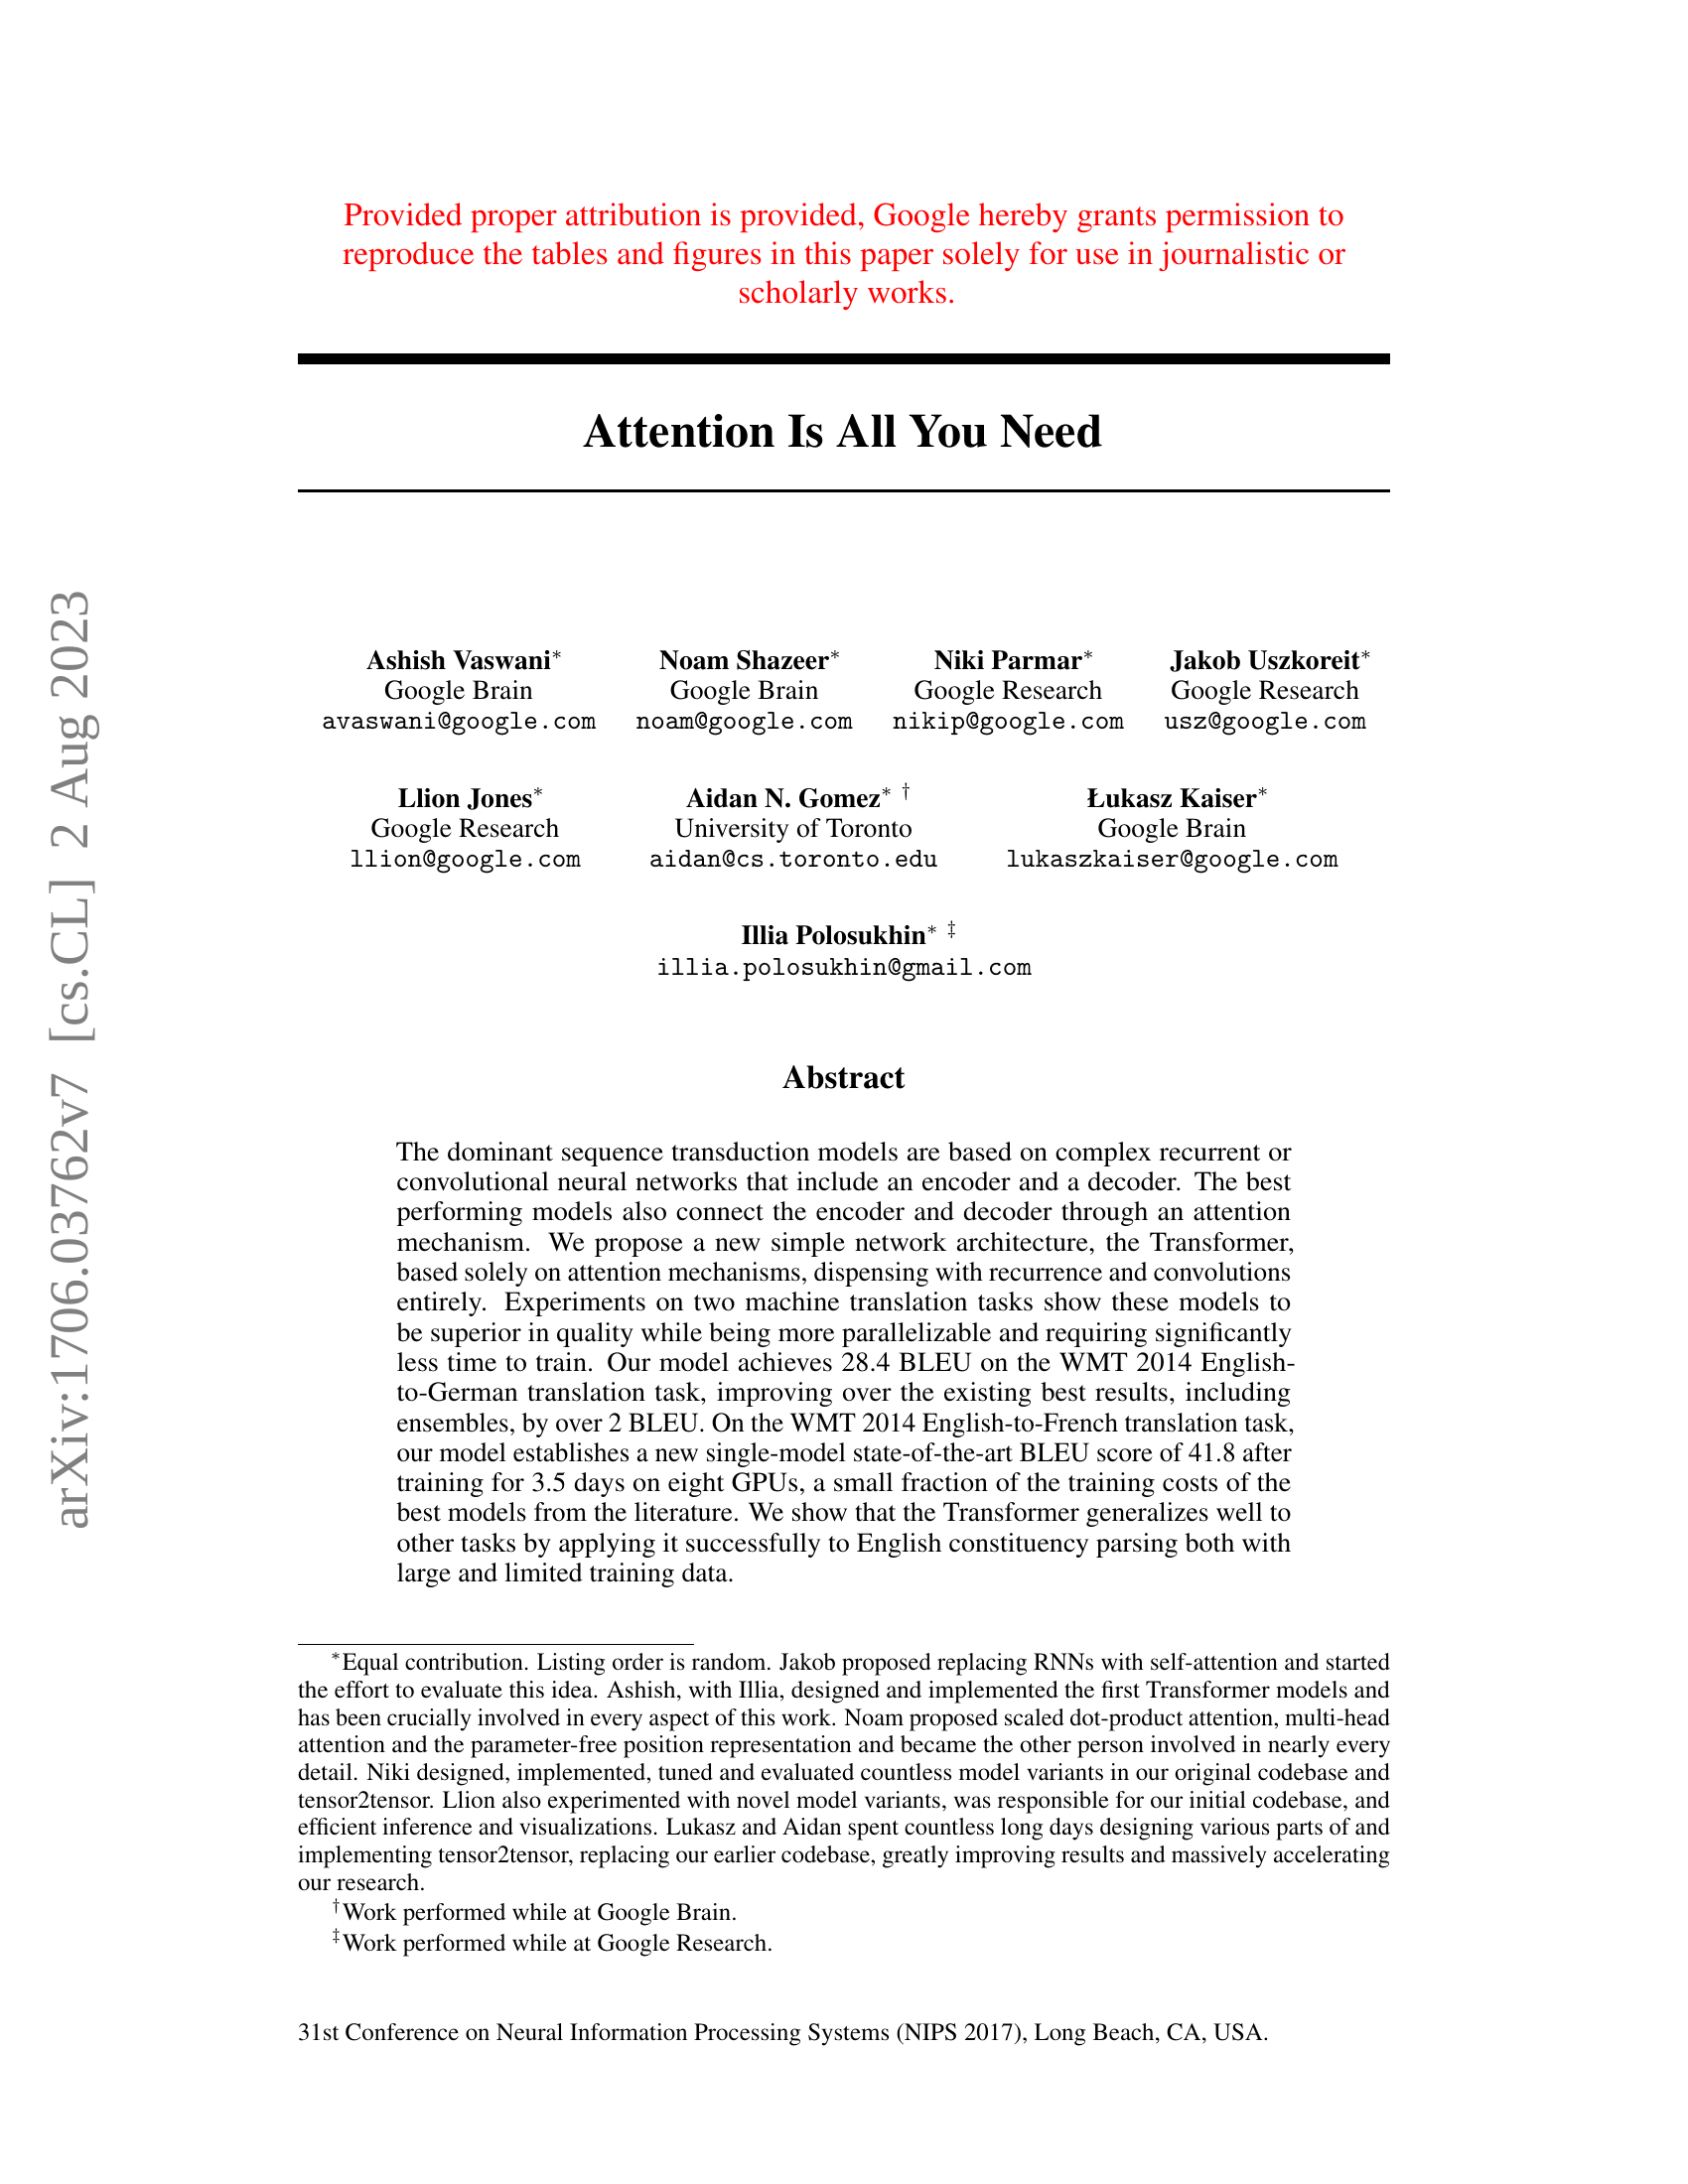

In [4]:
response = midras.embed_pdf("Attention_is_all_you_need.pdf", include_images=True)

images = response.images
embeddings = response.embeddings

print(f"Number of pages: {len(images)}")
images[0]

Now we have our embeddings, so we can use them to store data in our vector database along with any important information.

In this example, we create a for loop that goes through every image, and calls the *create_entry* method to create a list of entries with an id, a vector which will be use for search, and a payload which can be any information you want to attach to this vector. In this payload we are adding a field called "page_number" that is equal to the index of that page plus one. This is because indeces in python start at 0, so page 1 will have an index of 0, page 2 is index 1, and so on.

Once we have our list of entries, we can call the *save_entries* method to persists the entries to a specific collection. In this case the collection is "my_collection".

In [5]:
entries = []

for i in range(len(images)):
    entry = midras.index.create_entry(
        id=i, vector=embeddings[i], payload={"page_number": i + 1}
    )
    entries.append(entry)

midras.index.save_entries("my_collection", entries)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

Finally with our collection prepared, we can use the *query_text* utility method to run similarity search on the collection with any text input.

This method will return a queryresponse object with information of the top matching entries.

In [6]:
query = "Explain the architecture diagram proposed in this paper"

result = midras.query_text("my_collection", text=query)

We can then run this function to print the top 3 most relevant pages to our query.

In [7]:
relevant_pages = []

print("Top 3 relevant pages:", end=" ")

for point in result.points[:3]:
    page_number = point.payload["page_number"]
    relevant_pages.append(page_number)

    print(page_number, end=", ")

Top 3 relevant pages: 2, 3, 1, 

If we display those pages, we can see that they are the pages with the architecture diagrams and explanations.

Image 1:


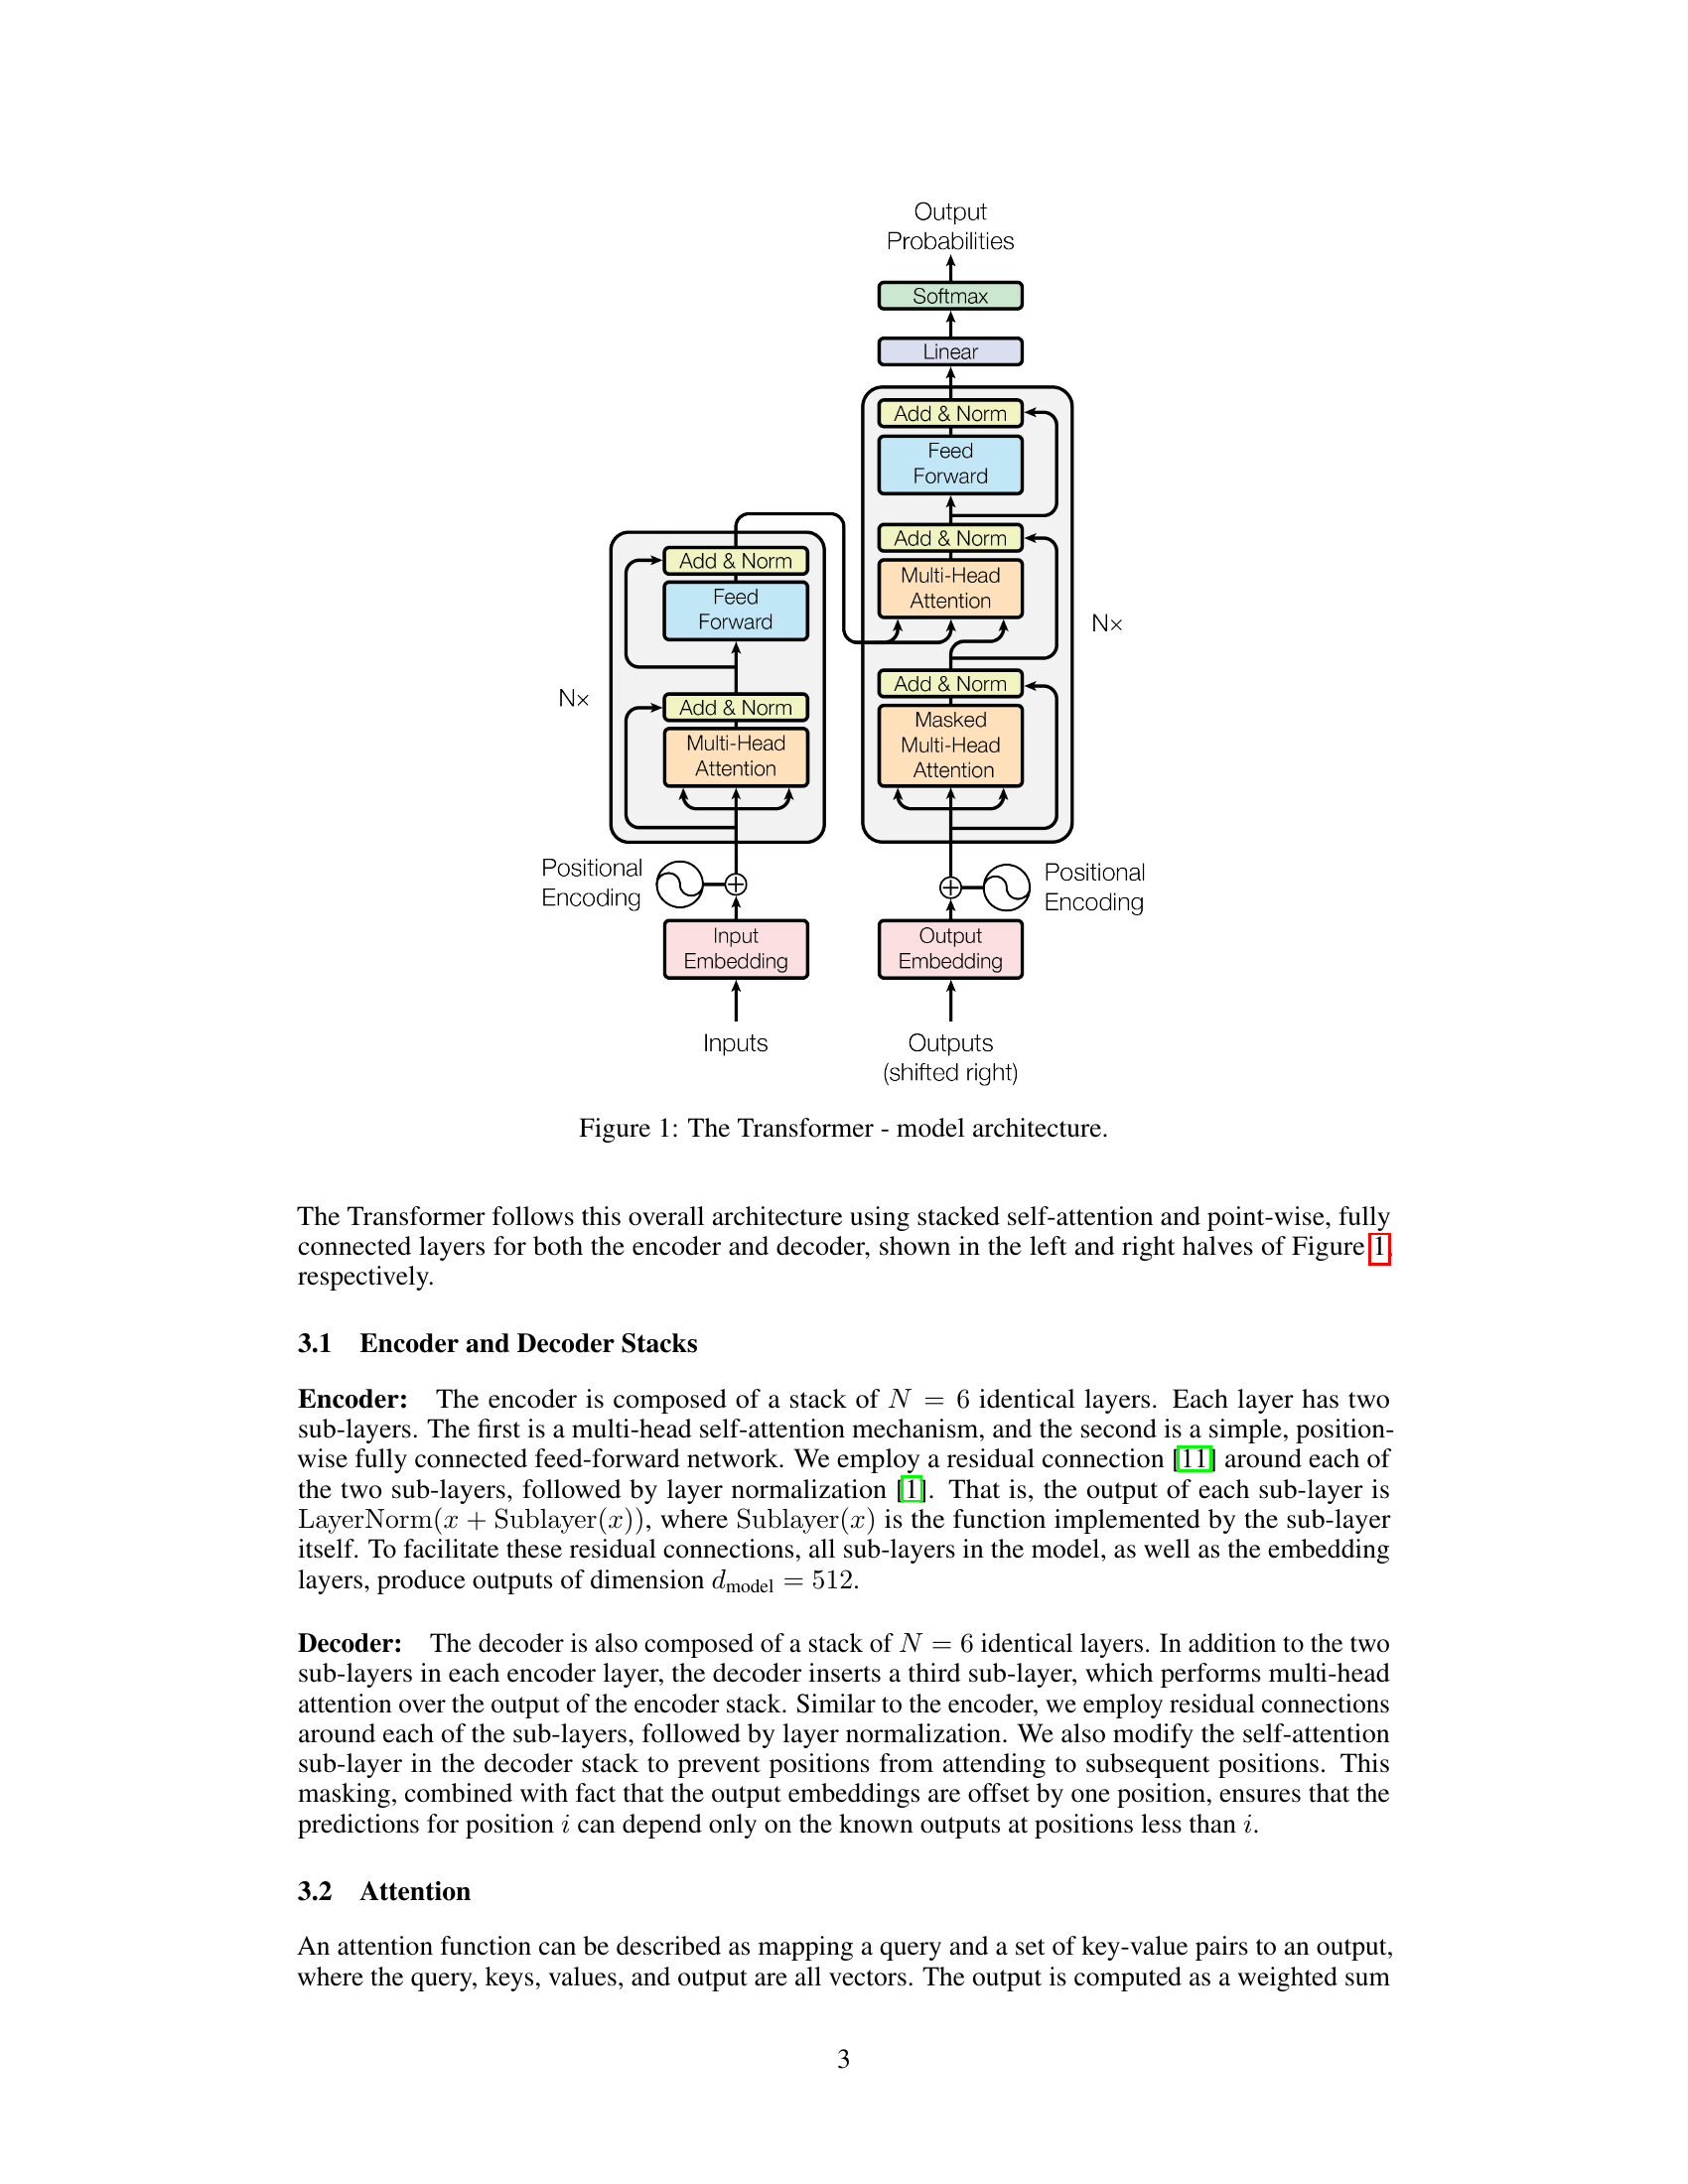



Image 2:


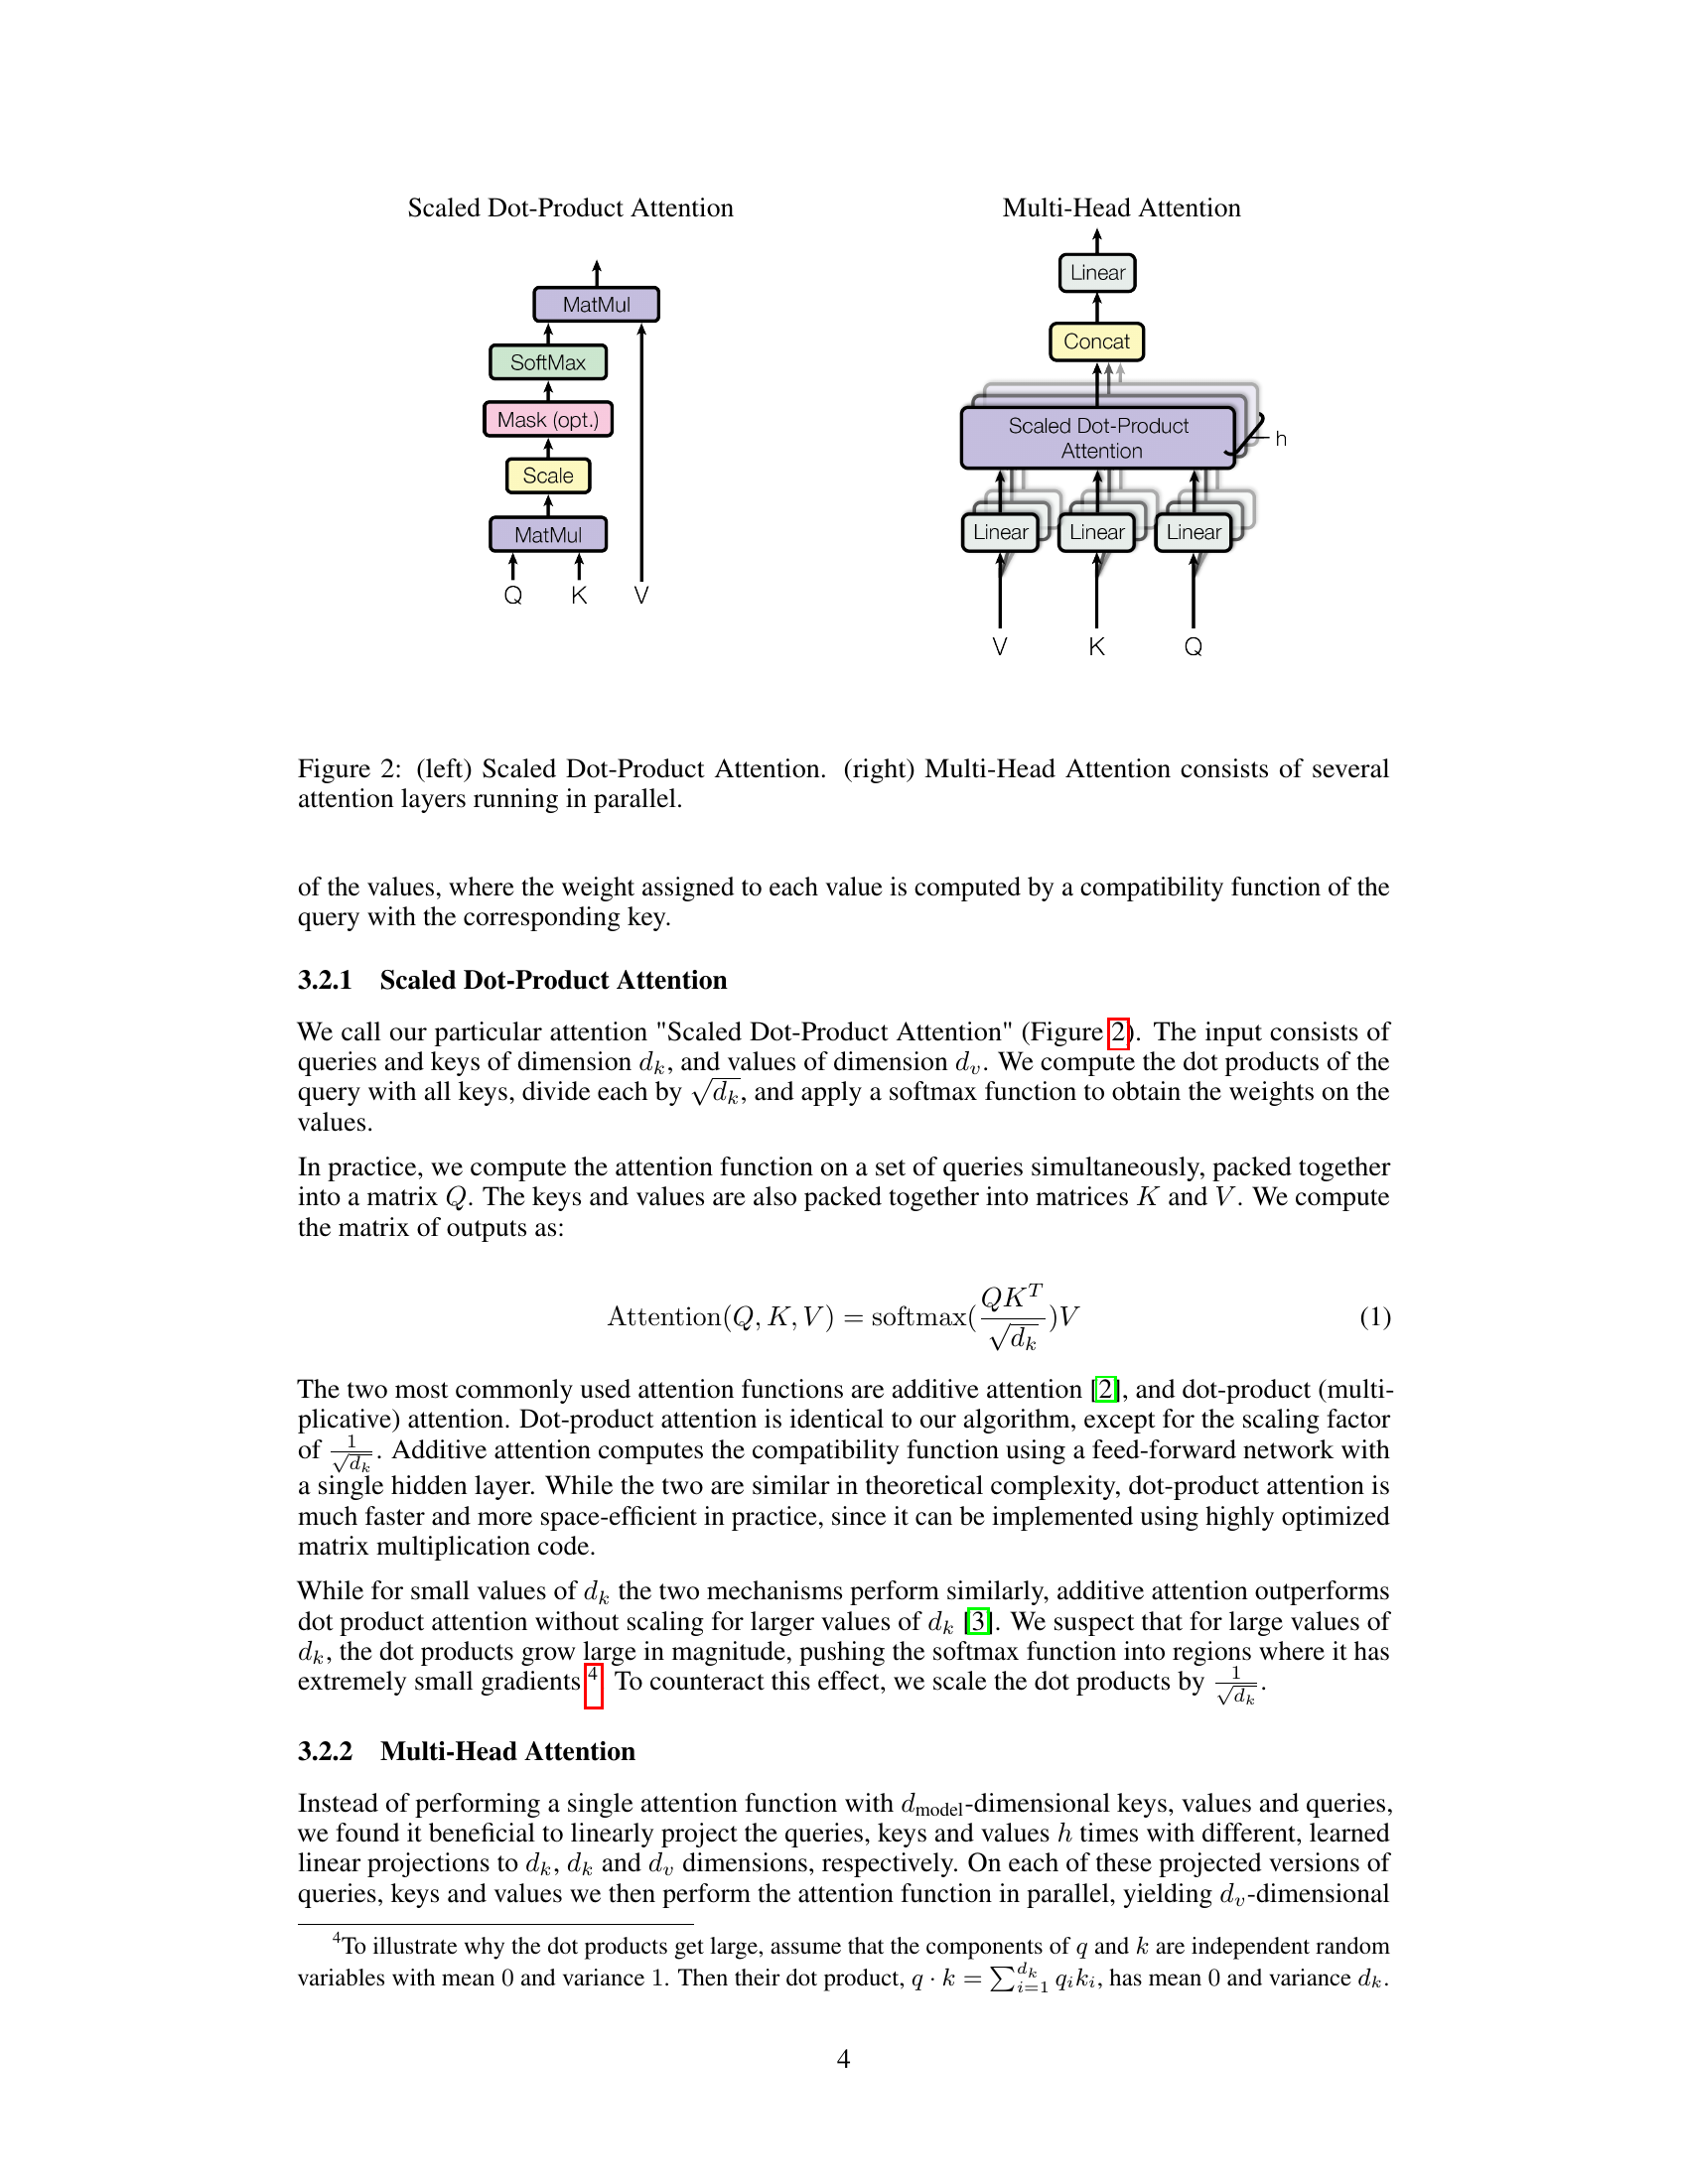



Image 3:


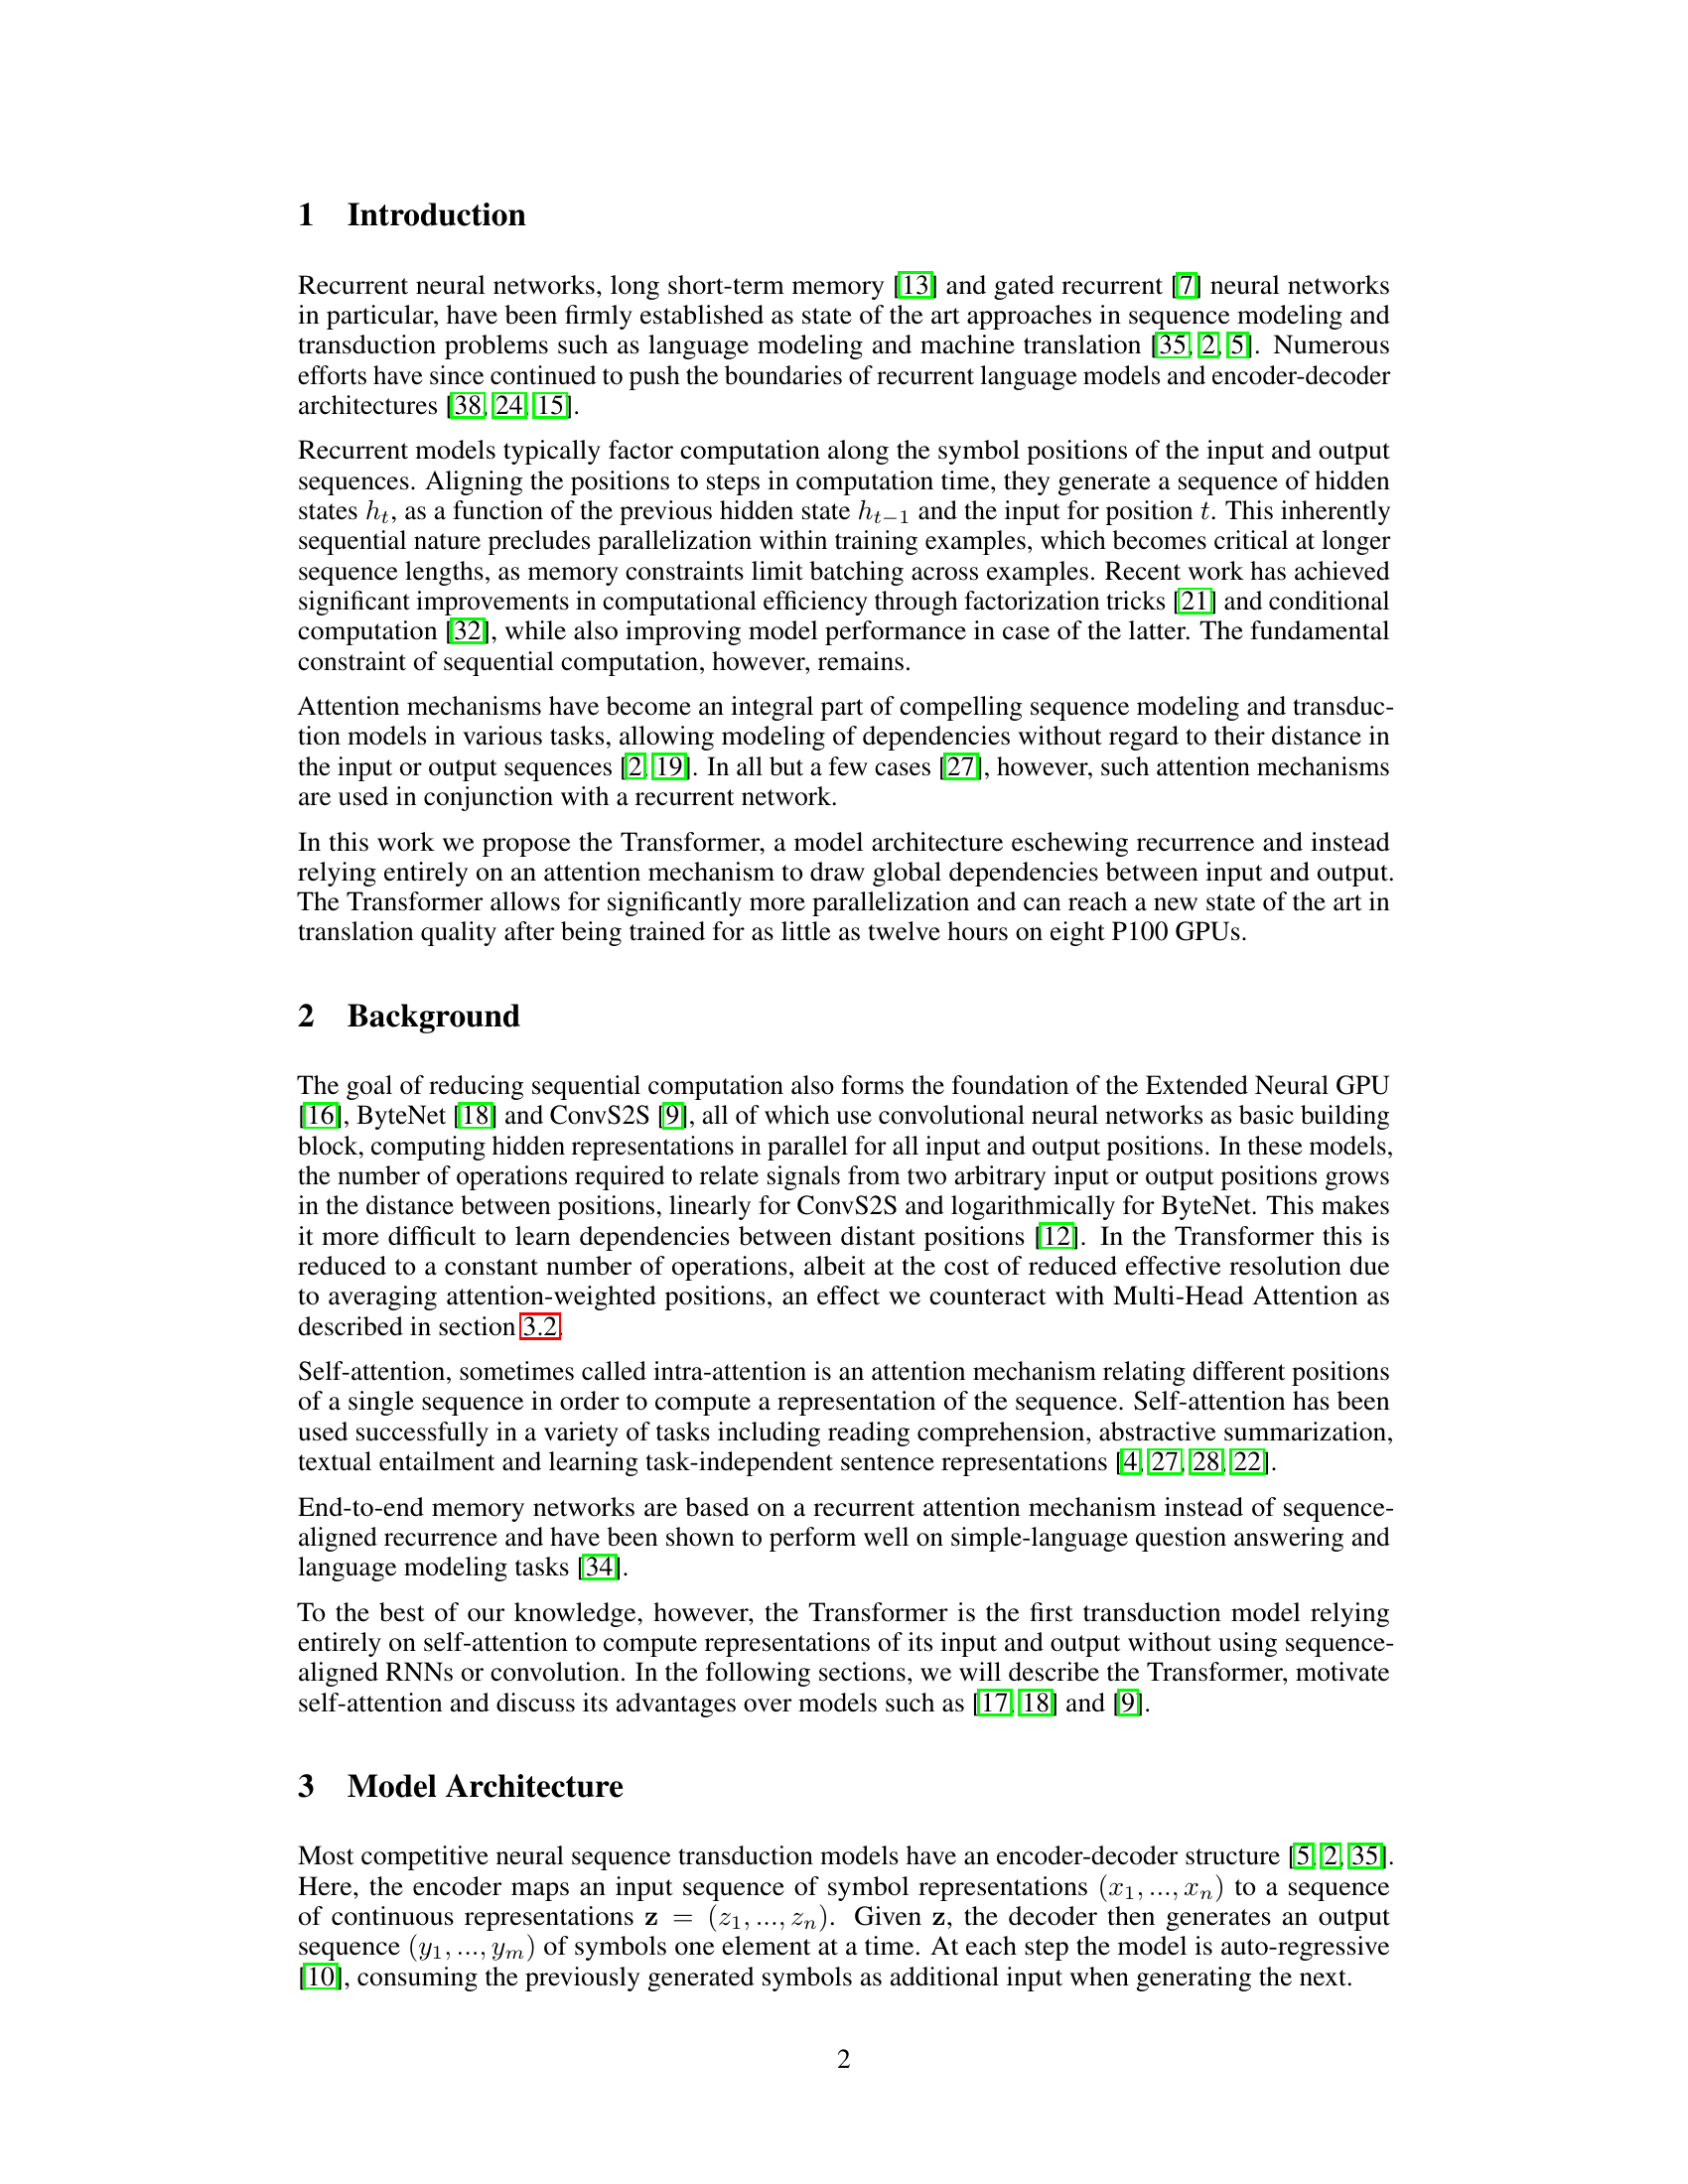

In [8]:
from IPython.display import display

for number, index in enumerate(relevant_pages):
    print(f"Image {number + 1}:")
    display(images[index])
    print("\n")

### Local Version

If you want to run the ColPali model that Midras uses, you'll need a GPU, I recommend at least a T4.

Also, you'll need to install some extra features from the midrasai package with the command:

```bash
pip install 'midrasai[local]'
```

This will download some additional dependencies such as Pytorch and Transformers needed to run the ColPali model locally.

By installing 'midrasai[local]' you will get access to the local namespace in the midrasai package.
This namespace hold two important classes:

    - ColPali, which is loads the ColPali model itself into your program.

    - ColPaliProcessor, which is used to run inference given an input and the model.

**NOTE:** You need to have permission to download the ColPali model from Huggingface. To do this, you'll have to follow these steps:

    1. Create a huggingface account

    2. Request access to ColPali

    3. Create an account token

    4. Authenticate from the cli with `huggingface-cli login`
    

In [9]:
from midrasai.local import ColPali, ColPaliProcessor

model = ColPali.initialize()
processor = ColPaliProcessor()

/home/anibal/p/midrasai/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anibal/p/midrasai/.venv/lib/python3.10/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
Some weights of ColPali were not initialized from the model checkpoint at google/paligemma-3b-mix-448 and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight', 'language_model.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now that the model is loaded, we can test creating an embedding like this:

In [10]:
test_embedding = processor.batch_embed_queries(model, ["This is a test"])
test_embedding

[[[-0.06640625,
   -0.1787109375,
   -0.05712890625,
   -0.140625,
   0.053955078125,
   0.0306396484375,
   -0.04931640625,
   -0.00799560546875,
   -0.04150390625,
   0.15234375,
   -0.1552734375,
   0.119140625,
   0.0810546875,
   -0.1494140625,
   0.056640625,
   0.08203125,
   0.1103515625,
   0.11474609375,
   -0.12158203125,
   0.1181640625,
   0.10791015625,
   -0.1025390625,
   0.0198974609375,
   0.06640625,
   0.08203125,
   0.01458740234375,
   0.2001953125,
   -0.09130859375,
   0.010986328125,
   0.0576171875,
   0.053955078125,
   -0.09033203125,
   0.10693359375,
   0.0478515625,
   -0.0157470703125,
   0.130859375,
   -0.13671875,
   -0.0093994140625,
   -0.00506591796875,
   -0.06591796875,
   -0.06591796875,
   0.1123046875,
   -0.1884765625,
   0.005218505859375,
   -0.146484375,
   -0.0181884765625,
   -0.08740234375,
   -0.052734375,
   -0.054931640625,
   0.06591796875,
   -0.0225830078125,
   -0.0191650390625,
   -0.06298828125,
   0.09375,
   0.033203125,
   0

Then we can create the necessary PIL images using the pdf2image package

`pip install pdf2image`

**NOTE**: This package depends on having poppler installed on your system.

In [11]:
from pdf2image import convert_from_path

images = convert_from_path("Attention_is_all_you_need.pdf")
images[:3]

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>]

We can the run the "batch_embed_images" method on our processor to create embeddings from these images.

I will use a for loop that processes images in batches of 5 to speed up inference.

In [12]:
embeddings = []
batch_size = 10

for i in range(0, len(images), batch_size):
    batch = images[i : i + batch_size]
    results = processor.batch_embed_images(model, batch)
    embeddings.extend(results)

len(embeddings)

15

Now let's set up our ColBERT compatible vector database with Qdrant.

The code below will create a new qdrant database in-memory and then create a new collection with multi-vector support called "my-local-collection"

In [13]:
from qdrant_client import QdrantClient, models

qdrant = QdrantClient(":memory:")

COLLECTION = "my_local_collection"

qdrant.create_collection(
    collection_name=COLLECTION,
    vectors_config=models.VectorParams(
        size=128,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
    ),
)

True

Now we can create our points, which are equivalent to Midras entries, and which are the objects that will be stored in the vector database with all the relevant information for each embedding.

In this case, for each embedding I will create a payload with the page number that embedding belongs to.

Once we have all our points we will upsert them to our qdrant collection.

In [14]:
points = [
    models.PointStruct(
        id=i,
        vector=embeddings[i],
        payload={
            "page_number": i + 1
        }
    )
    for i in range(len(images))
]

qdrant.upsert(COLLECTION, points)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

Finally, we can use the Qdrant Query API to search for results given a query vector.

In [15]:
query = "Explain the architecture diagram proposed in this paper"

query_embedding = processor.batch_embed_queries(model, [query])

result = qdrant.query_points(COLLECTION, query_embedding[0])
result

QueryResponse(points=[ScoredPoint(id=1, version=0, score=13.017175546164463, payload={'page_number': 2}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=2, version=0, score=12.592720738883063, payload={'page_number': 3}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=0, version=0, score=12.494990326803489, payload={'page_number': 1}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=4, version=0, score=12.3839217551573, payload={'page_number': 5}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=9, version=0, score=11.891535554320633, payload={'page_number': 10}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=3, version=0, score=11.8329373674377, payload={'page_number': 4}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=5, version=0, score=11.809247316476258, payload={'page_number': 6}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=8, version=0, score=11.732007225130106, payload={

Let's check out the top relevant pages acording to our search!

In [16]:
relevant_pages = []

print("Top 3 relevant pages:", end=" ")

for point in result.points[:3]:
    page_number = point.payload["page_number"]
    relevant_pages.append(page_number)

    print(page_number, end=", ")

Top 3 relevant pages: 2, 3, 1, 

Image 1:


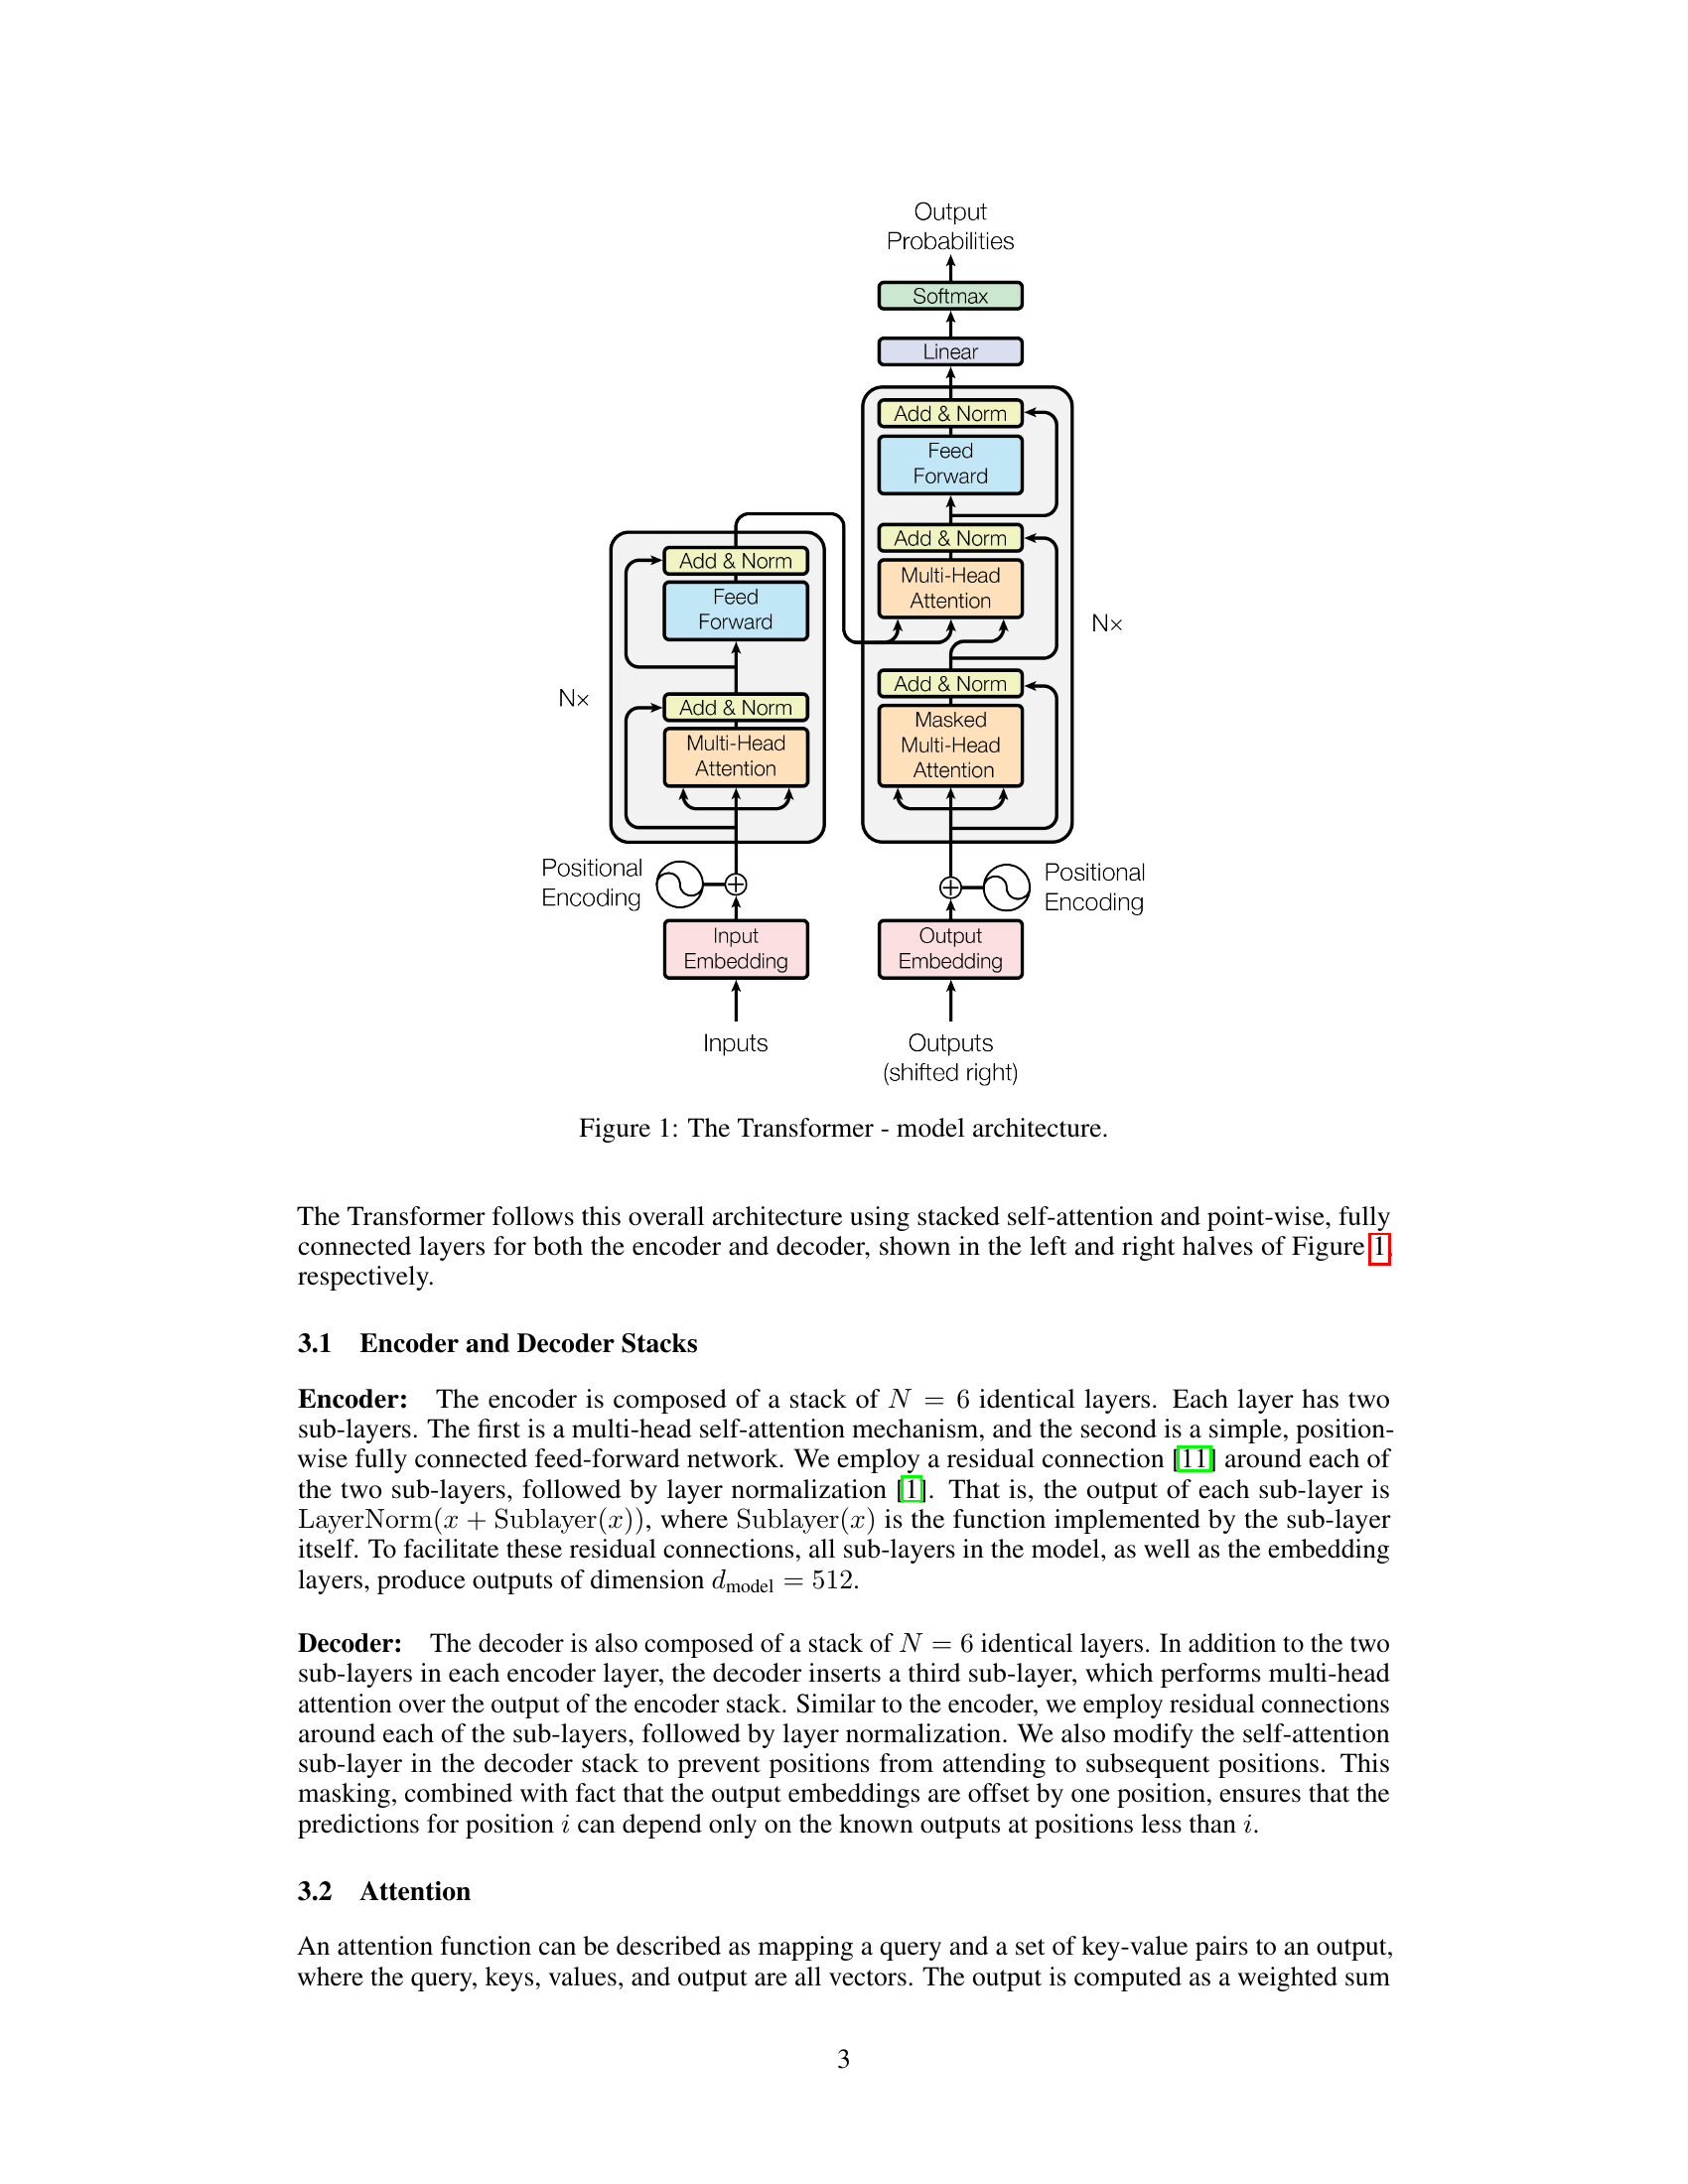



Image 2:


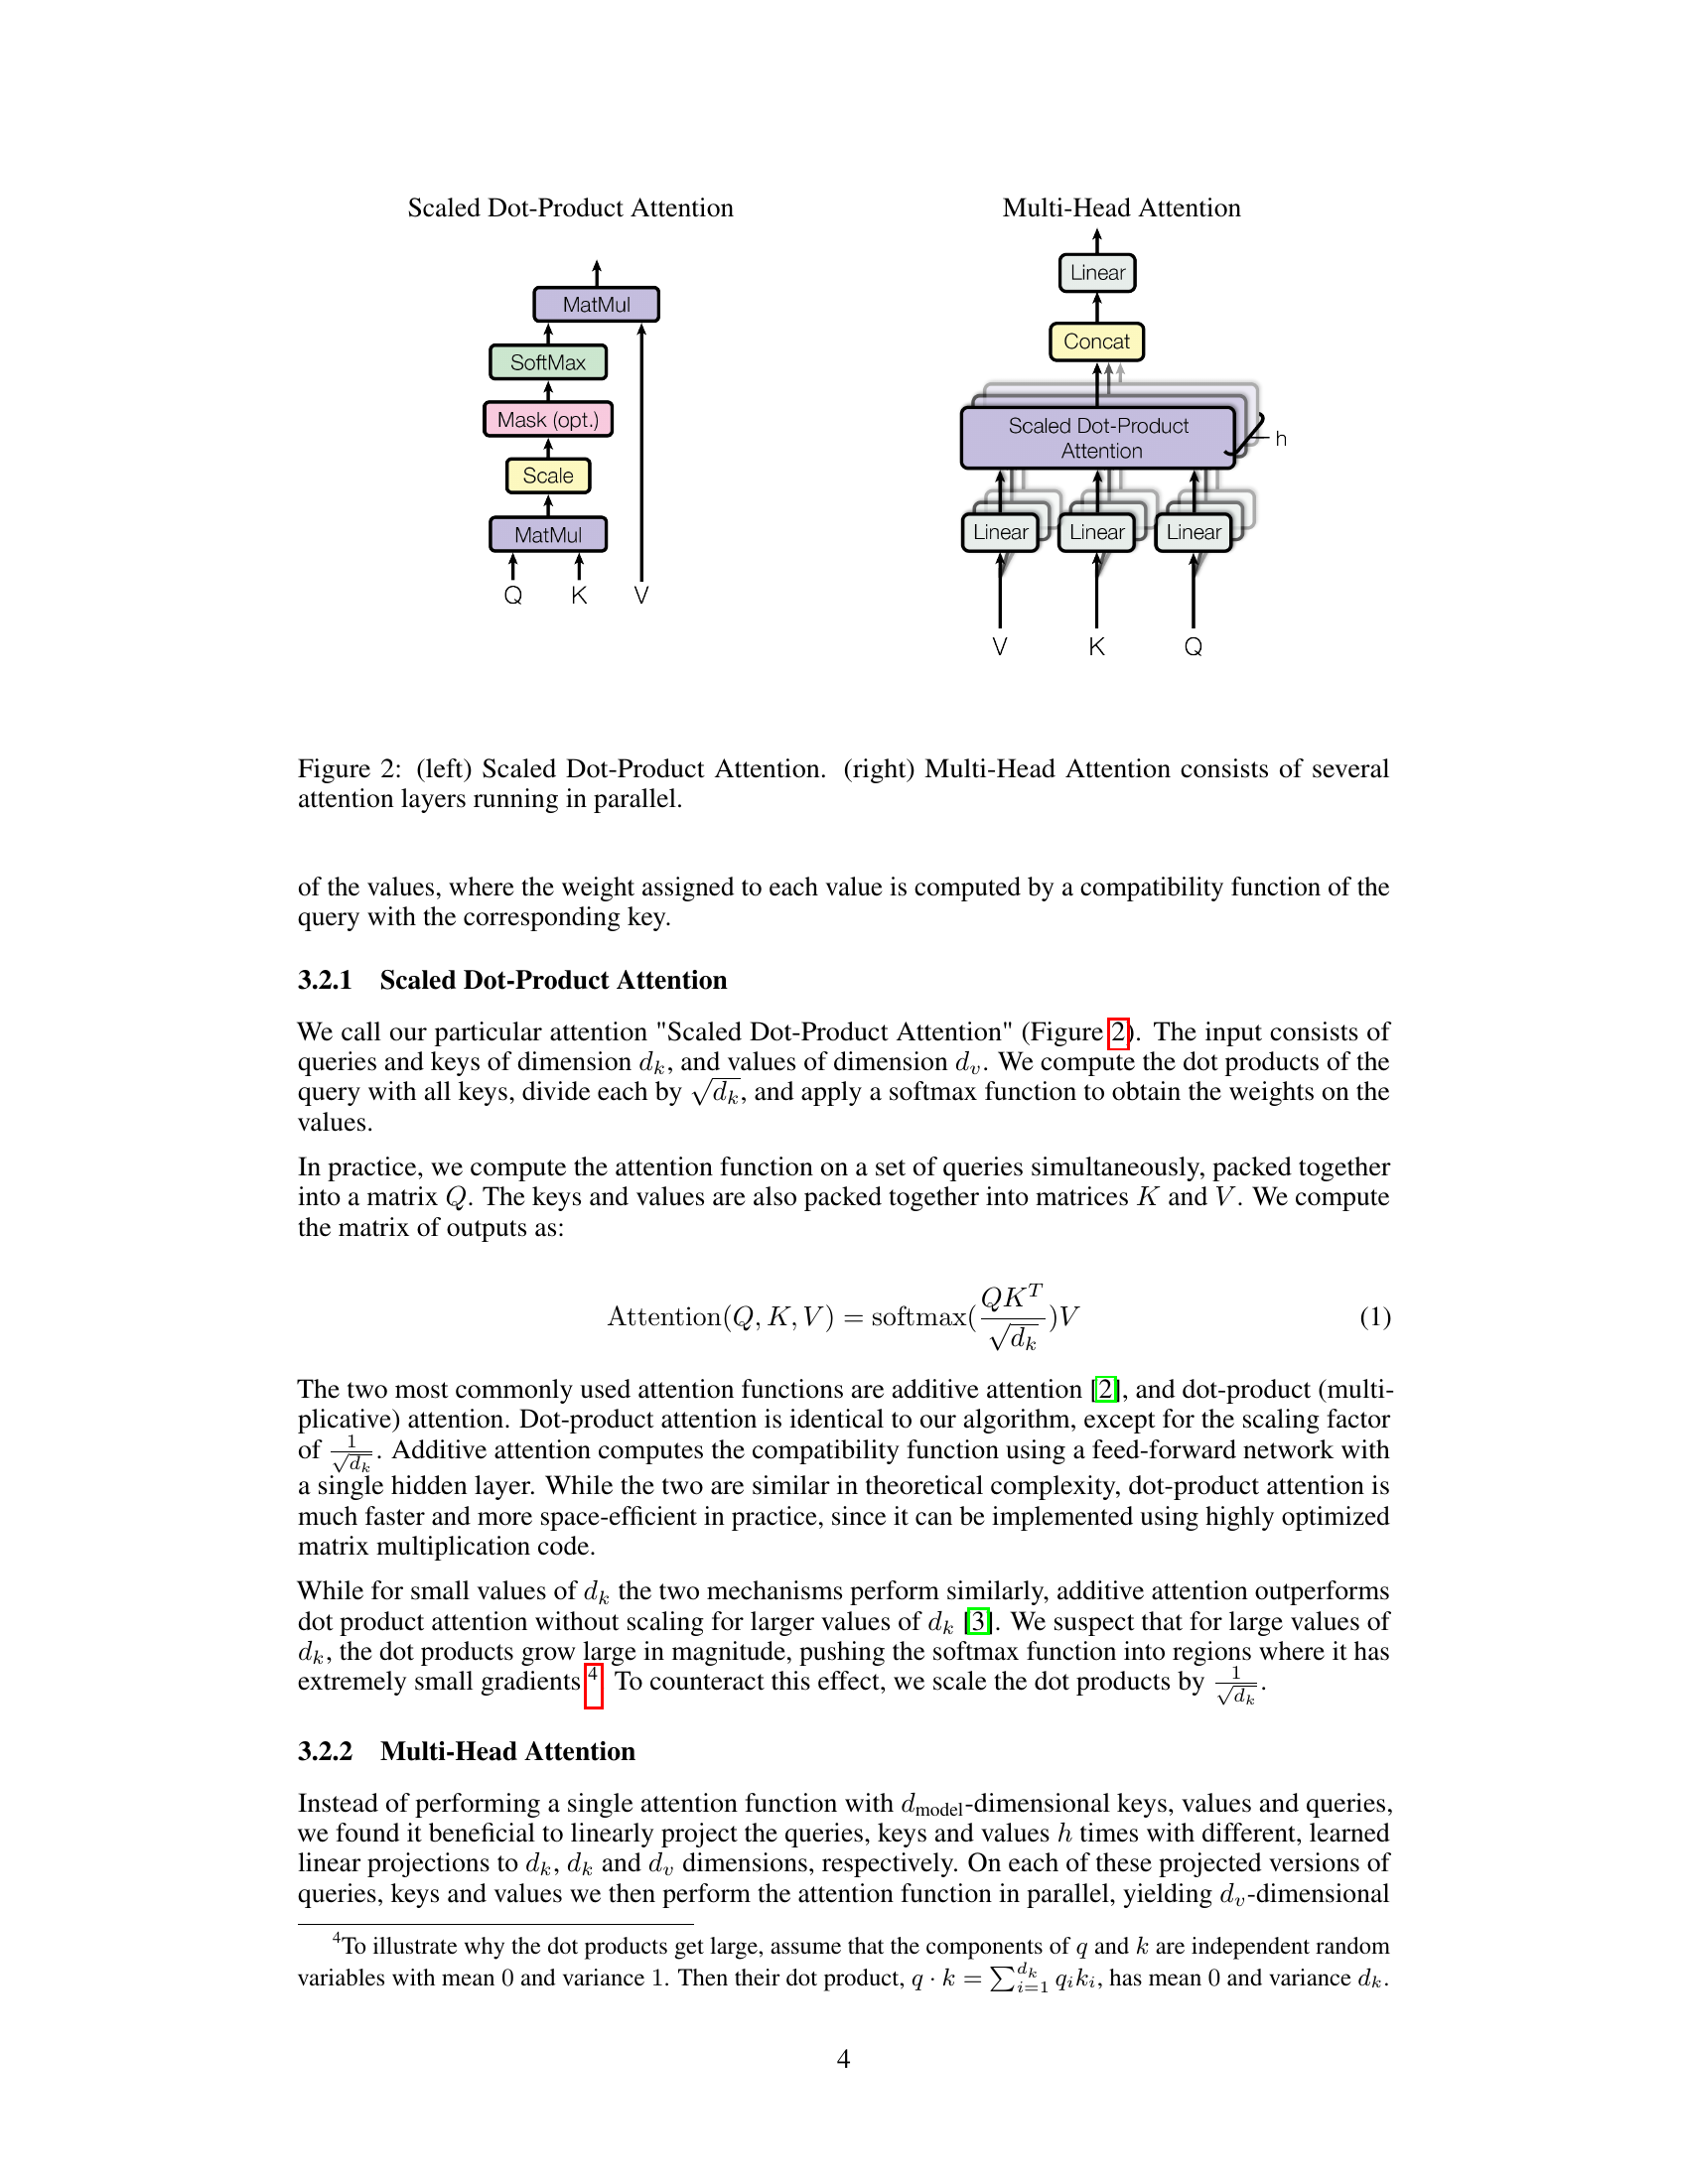



Image 3:


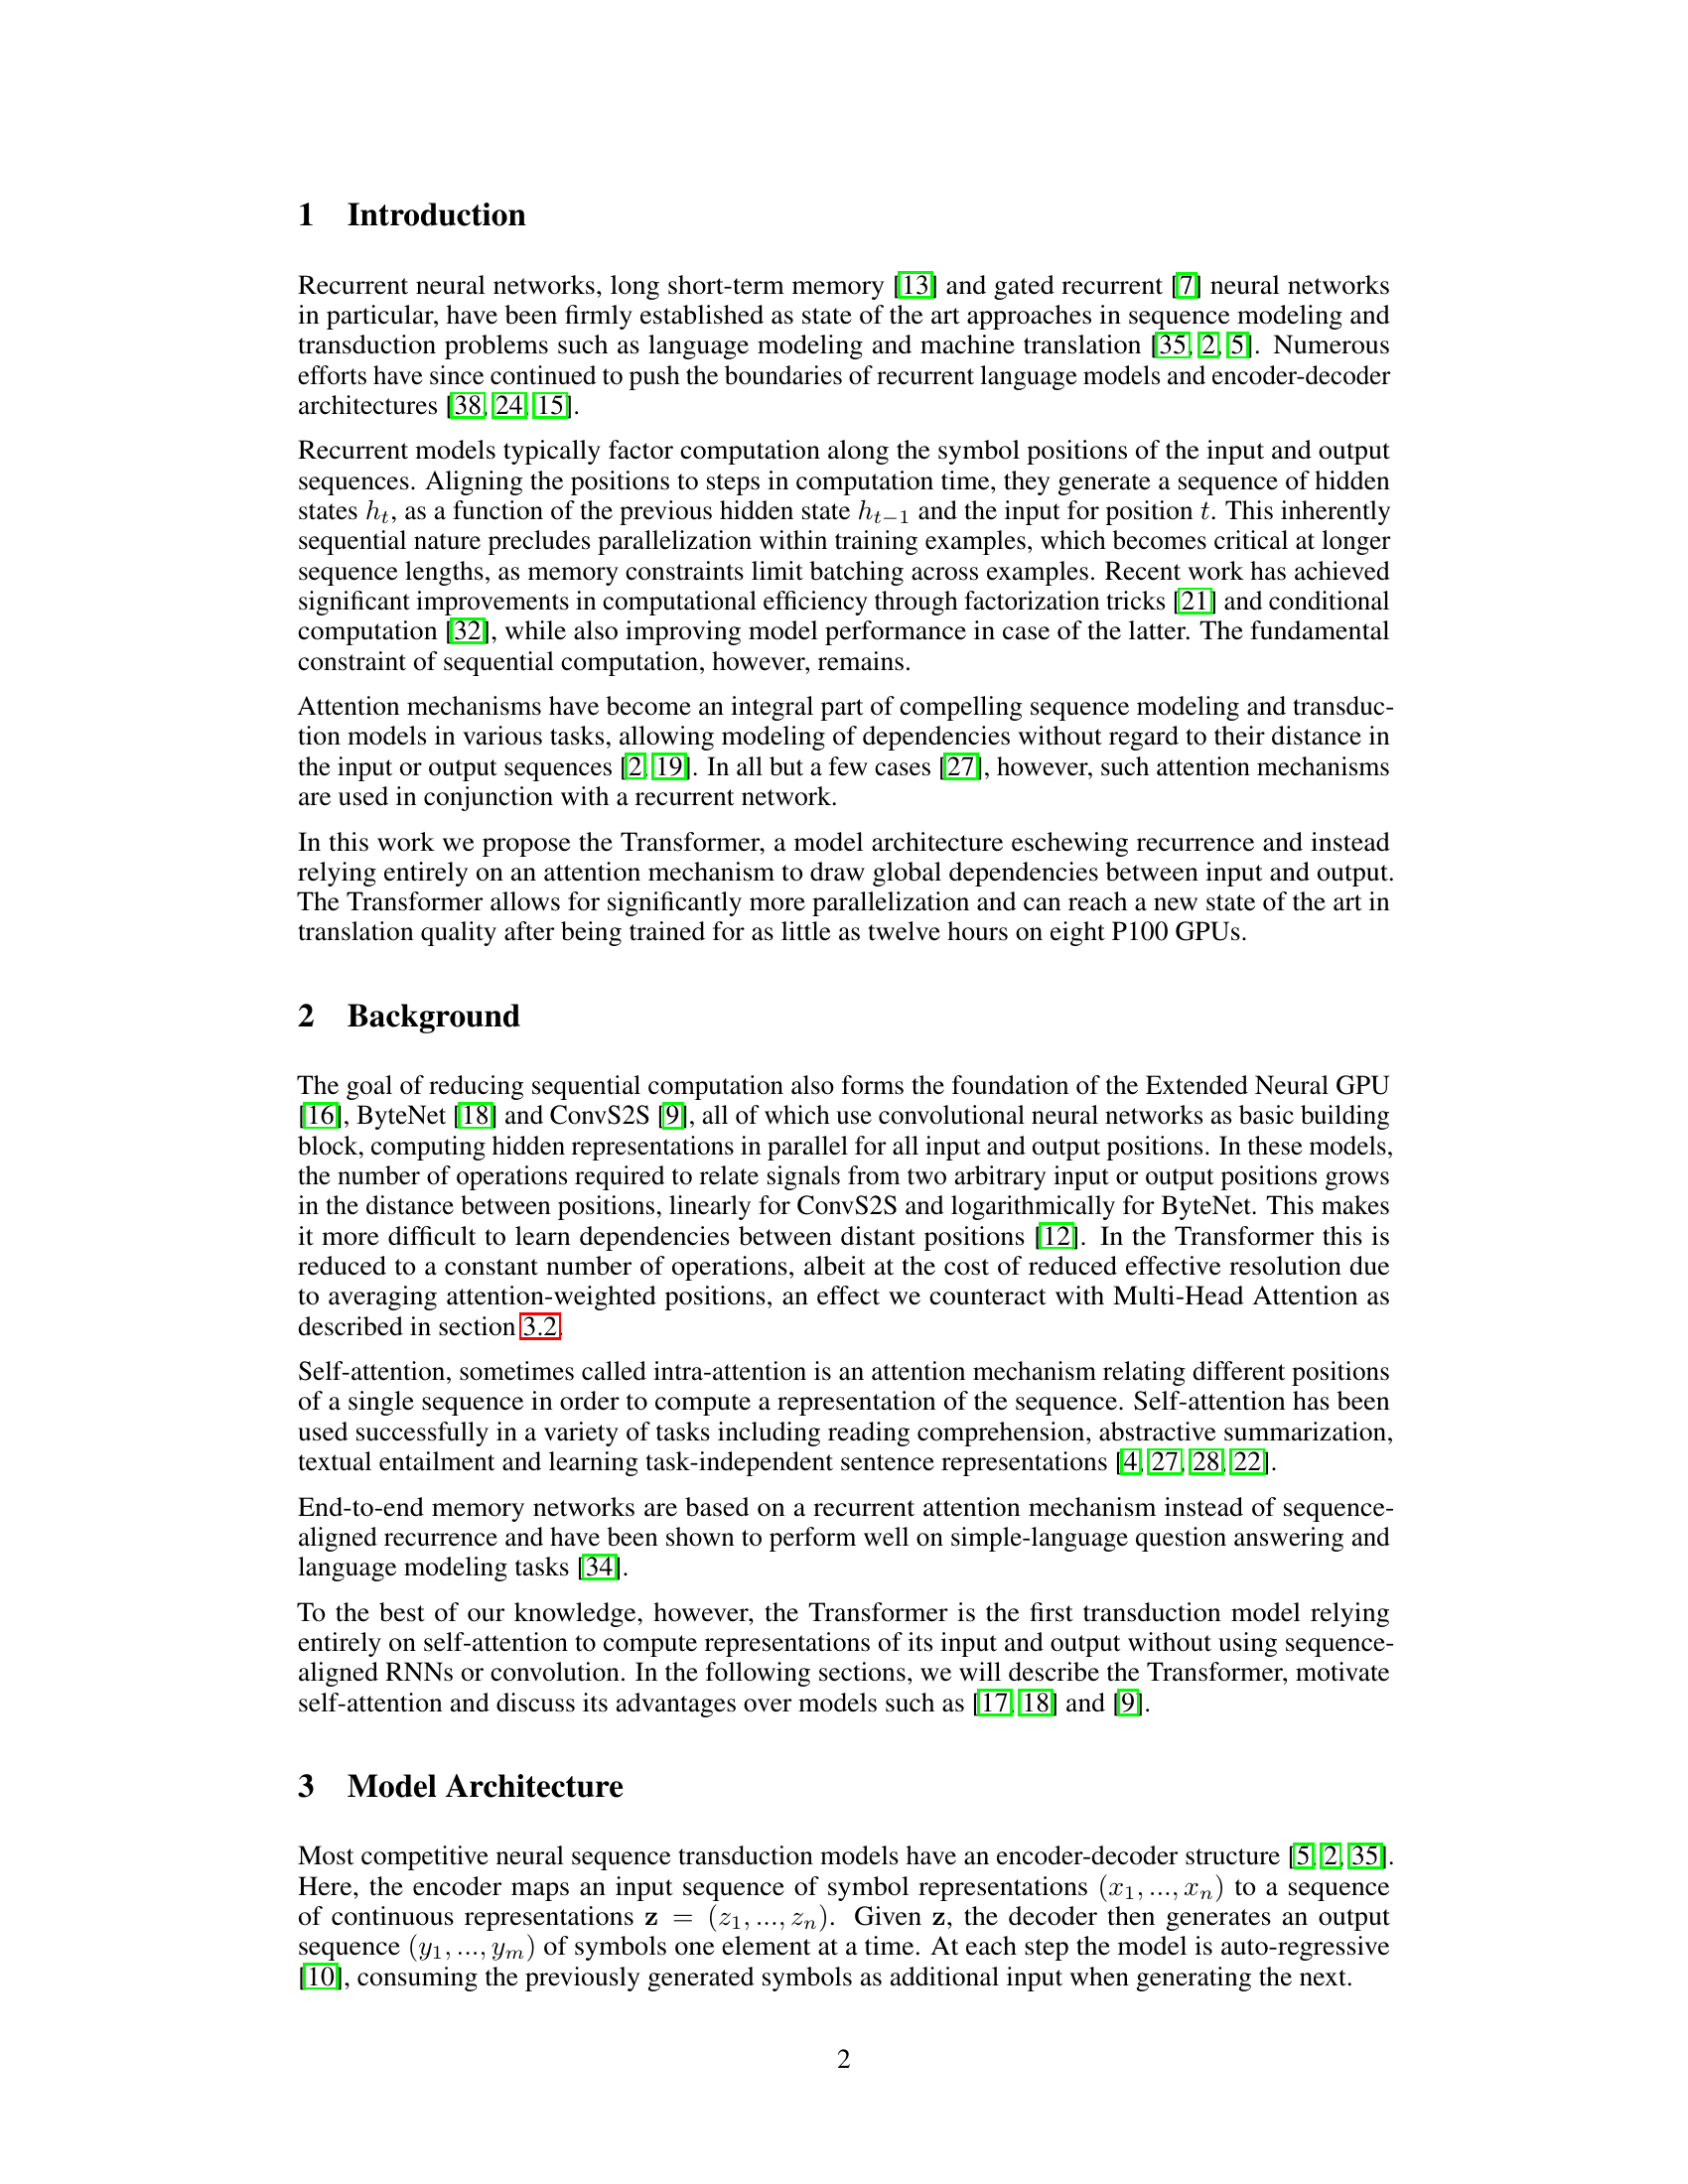

In [17]:
from IPython.display import display

for number, index in enumerate(relevant_pages):
    print(f"Image {number + 1}:")
    display(images[index])
    print("\n")